<a href="https://colab.research.google.com/github/Anderche/image_classification/blob/main/_Flower_Image_Classification_Anders_Kiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification for flower identification

### Anders Kiss

---

# **BUSINESS UNDERSTANDING**

The following code implementation is for an image classification model that predicts the **flower type** from an image file.

Three image classification models will be explored: 
- **a custom model**
- **ResNet50**
- **VGG16**

For each of the three types of models above, first a baseline model will be trained and evaluated and then a dropout layer will be added to each before being trained and evaluated.

In a real-world scenario, such a model could be utilized by hortoculturists and biologists in the field to identify species of flowers.

# **MODEL BACKGROUND**

## **ImageNet**

ImageNet was a project meant to labeling (manually) images for computer vision research purposes. The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) was an image classification challenge that could train a model to classify an input image into 1,000 separate object categories representing classes from dogs, cats, cars, etc. It can be used as a pretrained network into other models, such as ResNet50 and VGG16. The following image classification implementation applies 'transfer learning' by utilizing the feature learning layers of the ImageNet to classify images of a different problem.

## **ResNet50**

ResNet-50 is a 50-layer deep Convolutional Neural Network (CNN). The network has an image input size of 224-by-224. ResNet, short for Residual Networks, allow researchers to train very deep neural networks over 150 layers and was introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun ('Deep Residual Learning for Image Recognition', 2015). To overcome the "vanishing gradient problem" facing many CNN's during the backpropagation stage, ResNet's utilize a "skip connection" approach that skips certain model layers. 

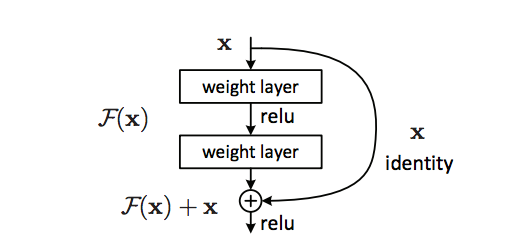

Reference: https://blog.devgenius.io/resnet50-6b42934db431

## **VGG16**

The VGG network architecture first introducted by Simonyan and Zisserman ('Very Deep Convolutional Networks for Large Scale Image Recognition', 2014) utilizes only 3×3 convolutional layers. Volume reduces via max pooling, before two fully-connected layers of 4,096 nodes each are followed by a softmax classifier. In terms of VGG16, and the alternative, VGG19, the “16” and “19” stand for the number of network weight layers.

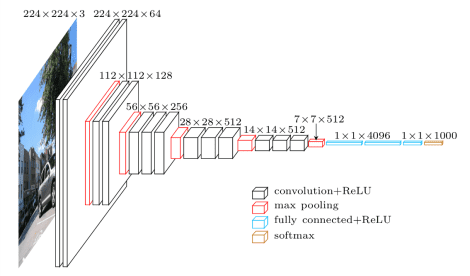

# **IMPORTS**

In [ ]:
import os
import zipfile

In [ ]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image
import pickle

In [ ]:
# os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle_dataset"

# **NOTES**

## **NOTE 01** - Connect to Kaggle API

This implementation uses the Kaggle API to download the flower dataset.

In order to replicate the following code, first authenticate your account by creating an API key.

1. Go to www.kaggle.com, create an account.
2. Navigate to the Account tab of your user profile and select Create API Token.
3. Download the kaggle.json file (containing your API credentials). 
4. Save it locally.
5. Upload the kaggle.json to the folder just created ("kaggle_dataset") within Google Drive in the following location.

Once completed, you can download the dataset to Google Drive.

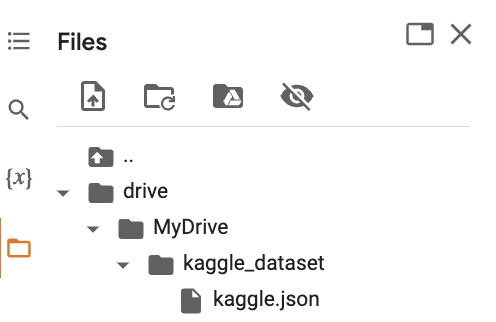

## **NOTE 02** - Switch to GPU 

_very helpful for speeding up training process that have 50 epochs_

1. Click Edit

2. Click Notebook settings

3. Change "Hardware accelerator" to "GPU"

4. Click Save

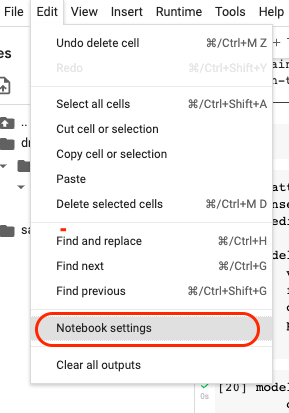

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /content/drive/MyDrive/kaggle_dataset. Or use the environment method.


In [ ]:
Zip_ref = zipfile.ZipFile("/content/flowers-recognition.zip")
Zip_ref.extractall("/tmp")
Zip_ref.close()

FileNotFoundError: ignored

In [ ]:
data_dir ="/tmp/flowers"

# **DATA UNDERSTANDING**

In [ ]:
((train_ds, train_labels), (test_ds, test_labels)), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels,
    with_info=True
)

In [ ]:
print('Flower types full list:')
print(ds_info.features['label'].names)

Flower types full list:
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(2569, 150, 150, 3)
(1101, 150, 150, 3)


# **DATA PREPARATION**

In [ ]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

# **MODELING**

## **VGG16 - Baseline Model**

In [ ]:
# ds_fig = tfds.show_examples(train_ds, ds_info, rows = 2, cols = 3)
# print(ds_fig)

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(2569, 150, 150, 3)
(1101, 150, 150, 3)


In [ ]:
## Loading VGG16 model
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
vgg_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(8, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    vgg_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
# model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

epochs=50
history = model.fit(
  train_ds,
  train_labels,
  validation_split=0.2, 
  batch_size=32,
  epochs=epochs,
  callbacks=[es]
)

Epoch 1/50
65/65 [==============================] - 29s 226ms/step - loss: 1.7669 - accuracy: 0.2647 - val_loss: 1.5408 - val_accuracy: 0.3307
Epoch 2/50
65/65 [==============================] - 12s 191ms/step - loss: 1.4461 - accuracy: 0.4209 - val_loss: 1.4343 - val_accuracy: 0.4300
Epoch 3/50
65/65 [==============================] - 12s 190ms/step - loss: 1.2974 - accuracy: 0.5046 - val_loss: 1.3575 - val_accuracy: 0.4494
Epoch 4/50
65/65 [==============================] - 12s 190ms/step - loss: 1.1533 - accuracy: 0.5470 - val_loss: 1.3312 - val_accuracy: 0.5039
Epoch 5/50
65/65 [==============================] - 12s 192ms/step - loss: 1.1104 - accuracy: 0.5732 - val_loss: 1.3002 - val_accuracy: 0.5136
Epoch 6/50
65/65 [==============================] - 12s 189ms/step - loss: 1.0436 - accuracy: 0.5830 - val_loss: 1.2760 - val_accuracy: 0.5019
Epoch 7/50
65/65 [==============================] - 12s 192ms/step - loss: 1.0041 - accuracy: 0.5893 - val_loss: 1.3817 - val_accuracy: 0.5389

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


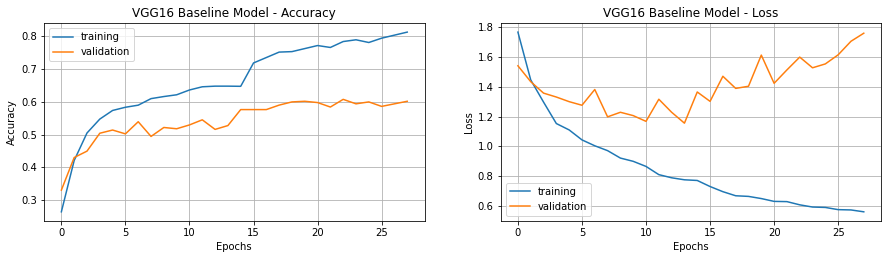

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('VGG16 Baseline Model - Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('VGG16 Baseline Model - Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()

plt.show()

In [ ]:
# SAVE MODEL
# PICKLE MODEL FOR FUTURE REFERENCE
pickle.dump(model, open('VGG16_baseline.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://50e6c38c-882c-4f99-bd3f-dbac6ecfc200/assets


INFO:tensorflow:Assets written to: ram://50e6c38c-882c-4f99-bd3f-dbac6ecfc200/assets


In [ ]:
# SAVE model to Google Drive for later use in Flask App
model.save('VGG16_baseline.h5')

In [ ]:
from numpy.core.fromnumeric import argmax
# top_acc = argmax(history.history['accuracy'])
top_acc = history.history['accuracy']
last_acc = (top_acc[-1]*100)
print("The latest accuracy score was: {}".format(last_acc))

The latest accuracy score was: 24.96350407600403


## **VGG16 - with Dropout**

In [ ]:
((train_ds, train_labels), (test_ds, test_labels)), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels,
    with_info=True
)

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(2569, 442, 1024, 3)
(1101, 442, 1024, 3)


In [ ]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(8, activation='relu')
dropout_layer_1 = layers.Dropout(0.2)
prediction_layer = layers.Dense(5, activation='softmax')

vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
vgg_model.trainable = False ## Not trainable weights

vgg_model_w_do = models.Sequential([
    vgg_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [ ]:
vgg_model_w_do.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
vgg_model_w_do.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 8)                 65544     
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 5)                 45        
                                                                 
Total params: 14,780,277
Trainable params: 65,589
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
# model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

epochs=50
history = vgg_model_w_do.fit(
  train_ds,
  train_labels,
  validation_split=0.2, 
  batch_size=32,
  epochs=epochs,
  callbacks=[es]
)

Epoch 1/50
65/65 [==============================] - 14s 197ms/step - loss: 1.7535 - accuracy: 0.2336 - val_loss: 1.6082 - val_accuracy: 0.2490
Epoch 2/50
65/65 [==============================] - 12s 189ms/step - loss: 1.6051 - accuracy: 0.2501 - val_loss: 1.6100 - val_accuracy: 0.2490
Epoch 3/50
65/65 [==============================] - 12s 188ms/step - loss: 1.6030 - accuracy: 0.2491 - val_loss: 1.6064 - val_accuracy: 0.2490
Epoch 4/50
65/65 [==============================] - 12s 190ms/step - loss: 1.6034 - accuracy: 0.2496 - val_loss: 1.6066 - val_accuracy: 0.2490
Epoch 5/50
65/65 [==============================] - 12s 189ms/step - loss: 1.6000 - accuracy: 0.2501 - val_loss: 1.6092 - val_accuracy: 0.2490
Epoch 6/50
65/65 [==============================] - 12s 189ms/step - loss: 1.5995 - accuracy: 0.2496 - val_loss: 1.6105 - val_accuracy: 0.2490


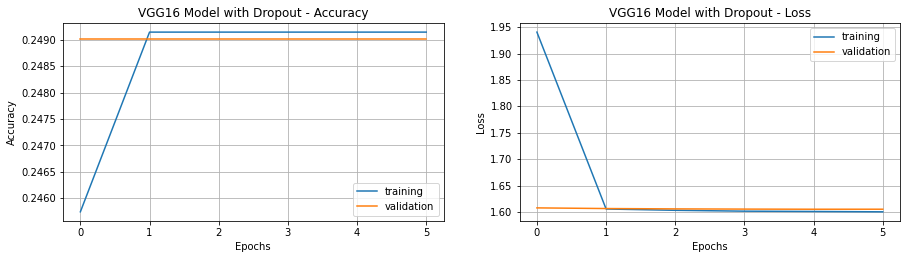

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('VGG16 Model with Dropout - Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('VGG16 Model with Dropout - Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()

plt.show()

In [ ]:
# SAVE MODEL
# PICKLE MODEL FOR FUTURE REFERENCE
# pickle.dump(resnet_model, open('VGG16_w_dropout.pkl', 'wb'))
pickle.dump(vgg_model_w_do, open('VGG16_w_dropout.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://63a18ff5-d4ba-4ebb-ad3c-d9ef9e8c340b/assets


INFO:tensorflow:Assets written to: ram://63a18ff5-d4ba-4ebb-ad3c-d9ef9e8c340b/assets


In [ ]:
# SAVE model to Google Drive for later use in Flask App
vgg_model_w_do.save('vgg_model_w_dropout.h5')

## **ResNet50 - Baseline Model**

In [ ]:
((train_ds, train_labels), (test_ds, test_labels)), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels,
    with_info=True
)

In [ ]:
## Resizing images
train_ds = tf.image.resize(train_ds, (224, 224))
test_ds = tf.image.resize(test_ds, (224, 224))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
print('Flower types full list:')
print(ds_info.features['label'].names)

Flower types full list:
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [ ]:
# ds_fig = tfds.show_examples(train_ds, ds_info, rows = 2, cols = 3)
# print(ds_fig)

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(2569, 224, 224, 3)
(1101, 224, 224, 3)


In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

## Loading ResNet50 model
ResNet50_model = ResNet50(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
ResNet50_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [ ]:
ResNet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(8, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

ResNet50_model = models.Sequential([
    ResNet50_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

ResNet50_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

# epochs=3
epochs=50
history = ResNet50_model.fit(
  train_ds,
  train_labels,
  validation_split=0.2, 
  batch_size=32,
  epochs=epochs,
  callbacks=[es]
)

Epoch 1/50
65/65 [==============================] - 32s 295ms/step - loss: 1.7708 - accuracy: 0.2365 - val_loss: 1.6082 - val_accuracy: 0.2490
Epoch 2/50
65/65 [==============================] - 16s 250ms/step - loss: 1.6064 - accuracy: 0.2487 - val_loss: 1.6071 - val_accuracy: 0.2490
Epoch 3/50
65/65 [==============================] - 16s 251ms/step - loss: 1.6046 - accuracy: 0.2487 - val_loss: 1.6063 - val_accuracy: 0.2490
Epoch 4/50
65/65 [==============================] - 16s 250ms/step - loss: 1.6032 - accuracy: 0.2487 - val_loss: 1.6059 - val_accuracy: 0.2490
Epoch 5/50
65/65 [==============================] - 16s 251ms/step - loss: 1.6022 - accuracy: 0.2487 - val_loss: 1.6055 - val_accuracy: 0.2490
Epoch 6/50
65/65 [==============================] - 16s 254ms/step - loss: 1.6014 - accuracy: 0.2487 - val_loss: 1.6053 - val_accuracy: 0.2490


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


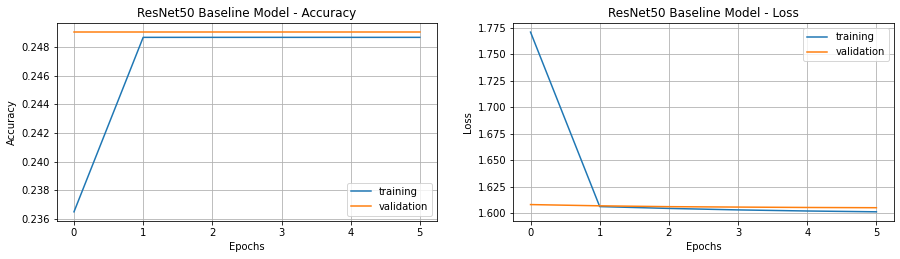

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('ResNet50 Baseline Model - Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('ResNet50 Baseline Model - Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()

plt.show()

In [ ]:
# SAVE MODEL
# PICKLE MODEL FOR FUTURE REFERENCE
pickle.dump(ResNet50_model, open('ResNet50_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://3fb5311c-6085-4375-93c8-67fa3b045294/assets


INFO:tensorflow:Assets written to: ram://3fb5311c-6085-4375-93c8-67fa3b045294/assets


In [ ]:
# SAVE model to Google Drive for later use in Flask App
ResNet50_model.save('ResNet50_model.h5')

## **ResNet50 Model - with Dropout**

In [ ]:
((train_ds, train_labels), (test_ds, test_labels)), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels,
    with_info=True
)

In [ ]:
## Resizing images
train_ds = tf.image.resize(train_ds, (224, 224))
test_ds = tf.image.resize(test_ds, (224, 224))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(8, activation='relu')
dropout_layer_1 = layers.Dropout(0.2)
prediction_layer = layers.Dense(5, activation='softmax')

ResNet50_model = ResNet50(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
ResNet50_model.trainable = False ## Not trainable weights

ResNet50_model_w_do = models.Sequential([
    ResNet50_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [ ]:
ResNet50_model_w_do.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
ResNet50_model_w_do.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 802824    
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 5)                 45        
                                                                 
Total params: 24,390,581
Trainable params: 802,869
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
# model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

epochs=50
history = ResNet50_model_w_do.fit(
  train_ds,
  train_labels,
  validation_split=0.2, 
  batch_size=32,
  epochs=epochs,
  callbacks=[es]
)

Epoch 1/50
65/65 [==============================] - 22s 278ms/step - loss: 1.9345 - accuracy: 0.2336 - val_loss: 1.6082 - val_accuracy: 0.2490
Epoch 2/50
65/65 [==============================] - 18s 279ms/step - loss: 1.6062 - accuracy: 0.2487 - val_loss: 1.6072 - val_accuracy: 0.2490
Epoch 3/50
65/65 [==============================] - 16s 252ms/step - loss: 1.6044 - accuracy: 0.2487 - val_loss: 1.6068 - val_accuracy: 0.2490
Epoch 4/50
65/65 [==============================] - 17s 258ms/step - loss: 1.6030 - accuracy: 0.2487 - val_loss: 1.6061 - val_accuracy: 0.2490
Epoch 5/50
65/65 [==============================] - 16s 253ms/step - loss: 1.6020 - accuracy: 0.2487 - val_loss: 1.6058 - val_accuracy: 0.2490
Epoch 6/50
65/65 [==============================] - 16s 253ms/step - loss: 1.6013 - accuracy: 0.2487 - val_loss: 1.6058 - val_accuracy: 0.2490


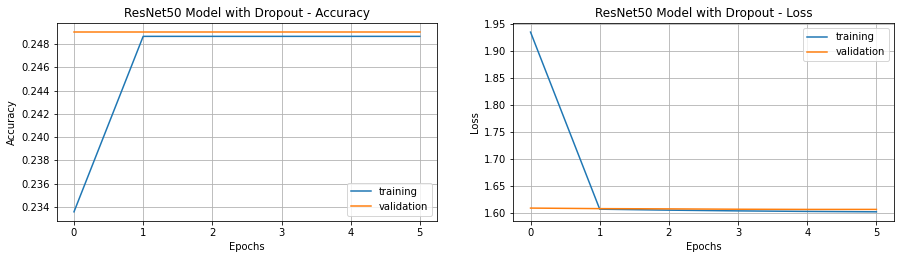

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('ResNet50 Model with Dropout - Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('ResNet50 Model with Dropout - Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()

plt.show()

In [ ]:
# SAVE MODEL
# PICKLE MODEL FOR FUTURE REFERENCE
pickle.dump(ResNet50_model_w_do, open('ResNet50_model_w_do.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://e2f41935-3ede-437b-980e-861820d7b93d/assets


INFO:tensorflow:Assets written to: ram://e2f41935-3ede-437b-980e-861820d7b93d/assets


In [ ]:
# SAVE model to Google Drive for later use in Flask App
ResNet50_model_w_do.save('ResNet50_model_w_do.h5')

## **CUSTOM Model - Baseline Model**

In [ ]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

custom_model = Sequential()
custom_model.add(Rescaling(1./255, input_shape=(150,150,3)))

custom_model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
custom_model.add(layers.MaxPooling2D(3))

custom_model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
custom_model.add(layers.MaxPooling2D(2))

custom_model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
custom_model.add(layers.MaxPooling2D(2))

custom_model.add(layers.Flatten())
custom_model.add(layers.Dense(20, activation='relu'))
custom_model.add(layers.Dense(10, activation='relu'))
custom_model.add(layers.Dense(5, activation='softmax'))

In [ ]:
custom_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 141, 141, 16)      4816      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)       

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

epochs=50
history = custom_model.fit(
  train_ds,
  train_labels,
  validation_split=0.2, 
  batch_size=32,
  epochs=epochs,
  callbacks=[es]
)

Epoch 1/50
65/65 [==============================] - 7s 57ms/step - loss: 1.5522 - accuracy: 0.3061 - val_loss: 1.4700 - val_accuracy: 0.3346
Epoch 2/50
65/65 [==============================] - 3s 41ms/step - loss: 1.4574 - accuracy: 0.3586 - val_loss: 1.3955 - val_accuracy: 0.3599
Epoch 3/50
65/65 [==============================] - 3s 41ms/step - loss: 1.3908 - accuracy: 0.3815 - val_loss: 1.5105 - val_accuracy: 0.2782
Epoch 4/50
65/65 [==============================] - 3s 41ms/step - loss: 1.3800 - accuracy: 0.4024 - val_loss: 1.3772 - val_accuracy: 0.3696
Epoch 5/50
65/65 [==============================] - 3s 40ms/step - loss: 1.3229 - accuracy: 0.4122 - val_loss: 1.3551 - val_accuracy: 0.3794
Epoch 6/50
65/65 [==============================] - 3s 41ms/step - loss: 1.3015 - accuracy: 0.4428 - val_loss: 1.2601 - val_accuracy: 0.4747
Epoch 7/50
65/65 [==============================] - 3s 40ms/step - loss: 1.2323 - accuracy: 0.4837 - val_loss: 1.2770 - val_accuracy: 0.4436
Epoch 8/50
65

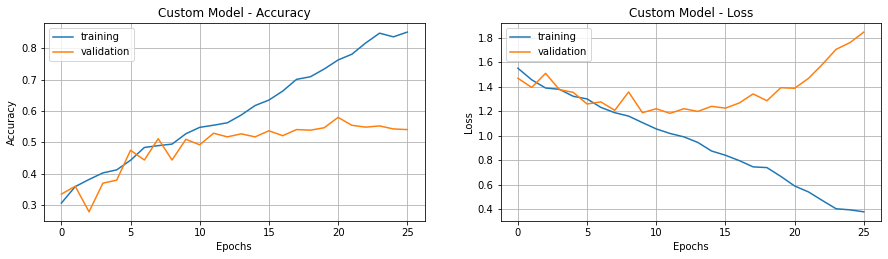

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Custom Model - Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Custom Model - Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()

plt.show()

In [ ]:
# SAVE MODEL
# PICKLE MODEL FOR FUTURE REFERENCE
pickle.dump(custom_model, open('custom_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://8a7e8549-66f0-45d1-8898-8961b825ff28/assets


INFO:tensorflow:Assets written to: ram://8a7e8549-66f0-45d1-8898-8961b825ff28/assets


In [ ]:
# SAVE model to Google Drive for later use in Flask App
custom_model.save('custom_model.h5')

## **CUSTOM Model - with Dropout**

In [ ]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

custom_model_w_dropout = Sequential()
custom_model_w_dropout.add(Rescaling(1./255, input_shape=(150,150,3)))

custom_model_w_dropout.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
custom_model_w_dropout.add(Dropout(0.2))
custom_model_w_dropout.add(layers.MaxPooling2D(3))

custom_model_w_dropout.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
custom_model_w_dropout.add(Dropout(0.2))
custom_model_w_dropout.add(layers.MaxPooling2D(2))

custom_model_w_dropout.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
custom_model_w_dropout.add(Dropout(0.2))
custom_model_w_dropout.add(layers.MaxPooling2D(2))

custom_model_w_dropout.add(layers.Flatten())
custom_model_w_dropout.add(layers.Dense(20, activation='relu'))
custom_model_w_dropout.add(layers.Dense(10, activation='relu'))
custom_model_w_dropout.add(layers.Dense(5, activation='softmax'))

In [ ]:
custom_model_w_dropout.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
custom_model_w_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 141, 141, 16)      4816      
                                                                 
 module_wrapper_3 (ModuleWra  (None, 141, 141, 16)     0         
 pper)                                                           
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 32)        32800     
                                                                 
 module_wrapper_4 (ModuleWra  (None, 40, 40, 32)      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
# model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

epochs=50
history = custom_model_w_dropout.fit(
  train_ds,
  train_labels,
  validation_split=0.2, 
  batch_size=32,
  epochs=epochs,
  callbacks=[es]
)

Epoch 1/50
65/65 [==============================] - 6s 62ms/step - loss: 1.5697 - accuracy: 0.2389 - val_loss: 1.5159 - val_accuracy: 0.3735
Epoch 2/50
65/65 [==============================] - 3s 52ms/step - loss: 1.4284 - accuracy: 0.3800 - val_loss: 1.3740 - val_accuracy: 0.4086
Epoch 3/50
65/65 [==============================] - 3s 50ms/step - loss: 1.3442 - accuracy: 0.4224 - val_loss: 1.3772 - val_accuracy: 0.4125
Epoch 4/50
65/65 [==============================] - 3s 51ms/step - loss: 1.3207 - accuracy: 0.4326 - val_loss: 1.3201 - val_accuracy: 0.4222
Epoch 5/50
65/65 [==============================] - 4s 56ms/step - loss: 1.2297 - accuracy: 0.4808 - val_loss: 1.2743 - val_accuracy: 0.4436
Epoch 6/50
65/65 [==============================] - 3s 49ms/step - loss: 1.2115 - accuracy: 0.4886 - val_loss: 1.2086 - val_accuracy: 0.4708
Epoch 7/50
65/65 [==============================] - 3s 46ms/step - loss: 1.1473 - accuracy: 0.5202 - val_loss: 1.2111 - val_accuracy: 0.4942
Epoch 8/50
65

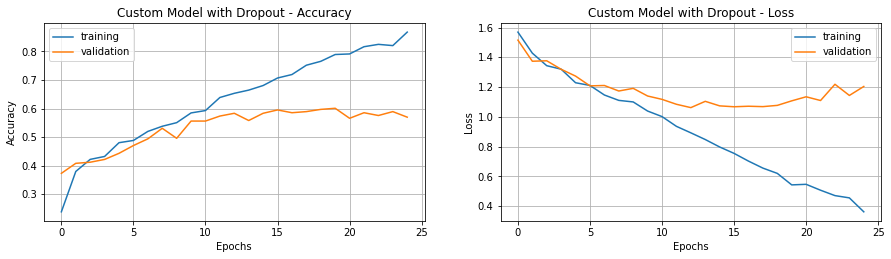

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Custom Model with Dropout - Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Custom Model with Dropout - Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epochs')  
plt.legend(['training', 'validation']) 
plt.grid()

plt.show()

In [ ]:
# SAVE MODEL
# PICKLE MODEL FOR FUTURE REFERENCE
pickle.dump(custom_model_w_dropout, open('custom_model_w_dropout.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://7dbb097b-e64d-433f-bf98-5891cfec0149/assets


INFO:tensorflow:Assets written to: ram://7dbb097b-e64d-433f-bf98-5891cfec0149/assets


In [ ]:
# SAVE model to Google Drive for later use in Flask App
custom_model_w_dropout.save('custom_model_w_dropout.h5')

NotImplementedError: ignored

# **EVALUATION**

### The following model plots show the evaluation metrics of Accuracy and Loss, in terms of the training set and validation set. Ideally, we want deploy a model with the highest accuracy possible, whereby the training and validation sets converge but not too closely (and thus signalling overfitting). 

### Based on the evaluation metrics, the best performing model was the **VGG16 baseline model**. **The accuracy on this model was 81%.** Even after switching to a GPU hardware accelerator within Google Colab, many of the epochs "timed out" typically after 7 runs. Ideally, all models would be compared to one another after 50 epochs.




## **VGG16 Model - Baseline**

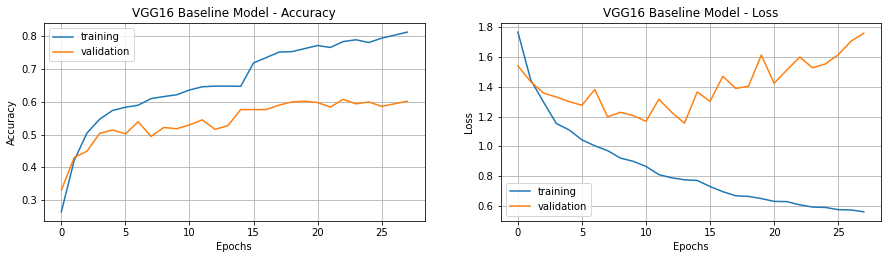

## **VGG16 Model with Dropout**

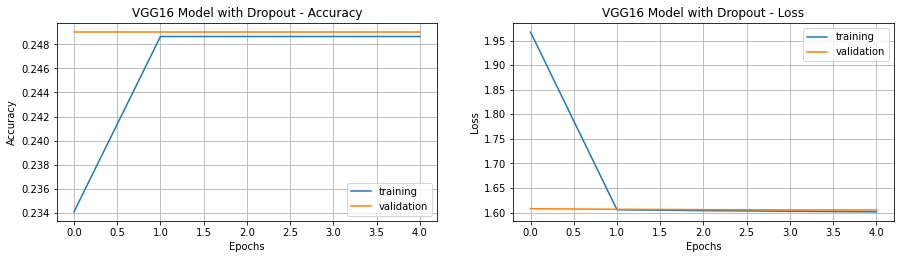

## **ResNet50 Model - Baseline**

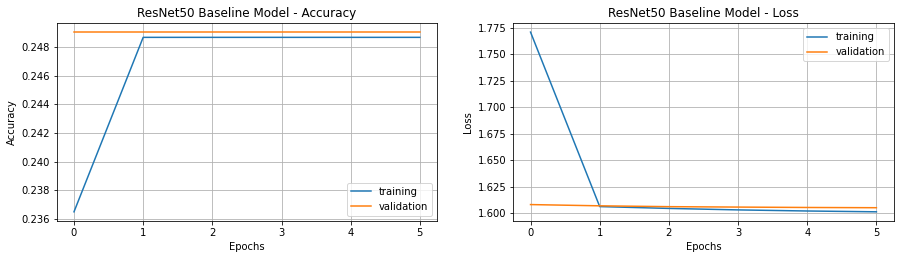

## **ResNet50 Model with Dropout**

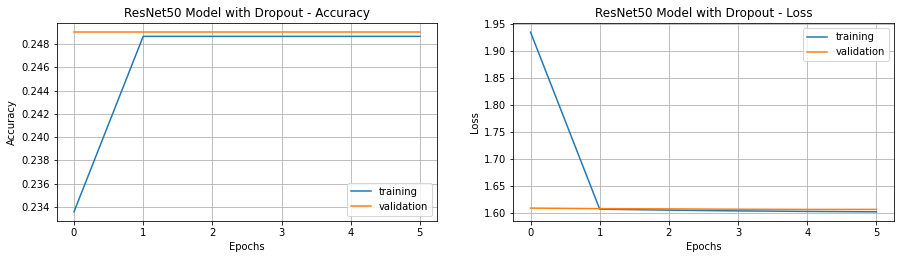

## **CUSTOM Model - Baseline**

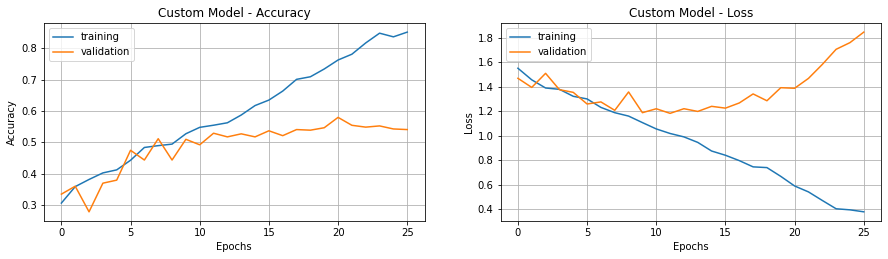

## **CUSTOM Model with Dropout**

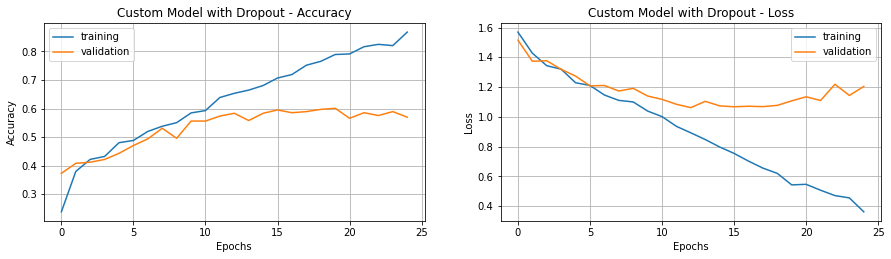

### The VGG16 (baseline) model was deployed to predict a new image.

### I tried to develop a Flask app, but could not get Tensorflow installed locally on my MacBook (I think it's an M1 chip issue).

In [ ]:
# LOAD VGG16 Baseline Model that was pickled earlier
file = open('VGG16_baseline.pkl', 'rb')
VGG16_model_v2 = pickle.load(file)
# close the file
file.close()

In [ ]:
classes = ds_info.features['label'].names
print(classes)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


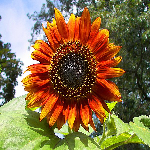

In [ ]:
from keras.preprocessing import image

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img_height,img_width = 150,150

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = VGG16_model_v2.predict(img_array)
score = tf.nn.softmax(predictions[0])

display(img)

In [ ]:
print(
    "The image is actually a sunflower.",
    "\n\nThe VGG16 model predicts that the image is most likely a: {}, with {:.2f}% confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

The image is actually a sunflower. 

The VGG16 model predicts that the image is most likely a: sunflowers, with 38.06% confidence.


# **REFERENCES**

- https://github.com/komalaftab/flower_classification/blob/main/flower_dataset.ipynb

- https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

- https://www.tensorflow.org/tutorials/images/classification

- https://pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

- https://learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/

- https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4